In [1]:
import qutip as qt
import numpy as np

from pyQTomo.labber_processing.nQubit_st import nQubitStateTomography
import matplotlib.pyplot as plt
import itertools as it
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import scipy.optimize as opt


plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics}')

In [10]:
GHZ_bool = True
W_bool = int(1-GHZ_bool)

if W_bool:
    log_data = r'..\..\Data\Fig4 Data\W\W_state_data.hdf5'
    log_beta = r'..\..\Data\Fig4 Data\W\BetaCalibration_WState.hdf5'

# GHZ state data
if GHZ_bool:
    log_data = r'..\..\Data\Fig4 Data\GHZ\GHZ_QST_data.hdf5'
    log_beta = r'..\..\Data\Fig4 Data\GHZ\BetaCalibration_GHZ.hdf5'
    log_CF = r'..\..\Data\Fig4 Data\GHZ\ConfusionMatrix_GHZ.hdf5'

In [11]:
#Create an instance of the nQubitStateTomography class and pass in the data

# Two methods of SPAM mitigation. Relengthening the Stokes vectors via a Rabi calibration experiment (beta calibration)
# Characterizing the readout confusion matrix and post-processing the results

if W_bool:
    tomo = nQubitStateTomography(log_data, 3, betasfile=log_beta, CF_file=None, QPT=False, index=0)
    betas, fits = tomo.getBetas(verbose=True)
    for i in range(3):
        print(betas[i])
if GHZ_bool:
    tomo = nQubitStateTomography(log_data, 3, betasfile=None, CF_file=log_CF, QPT=False, index=0)
    betas, fits = tomo.getBetas(verbose=True)
    cf_matrix = tomo.getCF_matrix()
    # print(cf_matrix)




(27, 8)


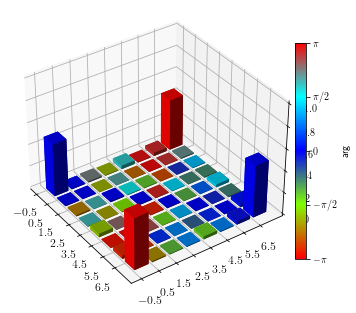

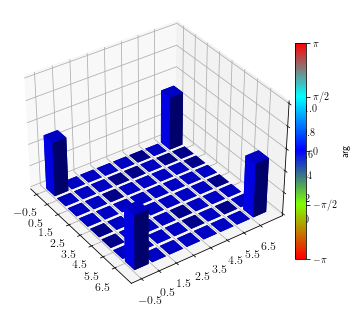

In [12]:
rho = tomo.getDMs()
rho = qt.Qobj(rho).unit()
rho.dims = [[2,2,2],[2,2,2]]
rhosq = rho*rho

GHZ = (qt.tensor([qt.basis(2,0)]*3) +
       qt.tensor([qt.basis(2,1)]*3)).unit()
       
W = (qt.tensor([qt.basis(2,1), qt.basis(2,0), qt.basis(2,0)]) +
     qt.tensor([qt.basis(2,0), qt.basis(2,1), qt.basis(2,0)]) +
     qt.tensor([qt.basis(2,0), qt.basis(2,0), qt.basis(2,1)])).unit()

GHZ_dm = qt.ket2dm(GHZ)
W_dm = qt.ket2dm(W)

if W_bool:
    state = W
    state_dm = W_dm
if GHZ_bool:
    state = GHZ
    state_dm = GHZ_dm

#print(f'Purity of the prepared input state is: {rhosq.tr()}')

fig, ax = qt.visualization.matrix_histogram_complex(rho)
plt.show()

fig, ax = qt.visualization.matrix_histogram_complex(state_dm)
plt.show()

In [13]:
def rotate_matrix(rho, theta):
    if len(theta)==1:
        rz = qt.tensor([qt.qeye(2), 
                        qt.qeye(2), 
                        qt.qip.operations.rz(theta[0]*np.pi)])

    else:
        rz = qt.tensor([qt.qip.operations.rz(theta[0]*np.pi), 
                        qt.qip.operations.rz(theta[1]*np.pi), 
                        qt.qip.operations.rz(theta[2]*np.pi)])
    
    rho_rot = rz*rho*rz.dag()
    return rho_rot
    
def opt_angle(theta, rho, rho_true):
    rho_rot = rotate_matrix(rho, theta)
    return 1 - qt.fidelity(rho_rot, rho_true)**2

In [14]:

if GHZ_bool:
    res = opt.minimize(opt_angle, 
                       [0.0], 
                       args=(rho, state_dm),
                       method='Powell')


if W_bool:
    res = opt.minimize(opt_angle, 
                       [0.0, 0.0, 0.0], 
                       args=(rho, state_dm),
                       method='Powell')

print(res.x)
print(1-res.fun)

[1.01011212]
0.9560533129358944


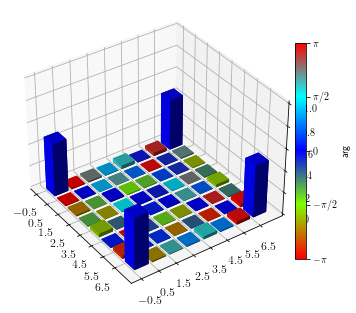

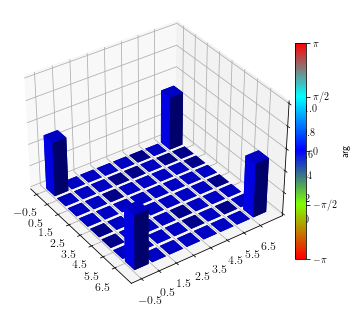

0.9560533129358944


In [15]:
rho_rot = rotate_matrix(rho, res.x)

fig, ax = qt.visualization.matrix_histogram_complex(rho_rot.unit())
plt.show()

fig, ax = qt.visualization.matrix_histogram_complex(state_dm)
plt.show()



print(qt.fidelity(rho_rot, state_dm)**2)

In [16]:
def sph2cart(r, theta, phi):
    '''spherical to Cartesian transformation.'''
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def sphview(ax):
    '''returns the camera position for 3D axes in spherical coordinates'''
    r = np.square(np.max([ax.get_xlim(), ax.get_ylim()], 1)).sum()
    theta, phi = np.radians((90-ax.elev, ax.azim))
    return r, theta, phi
#
# end of apodemus's code

def getDistances(view):
    distances  = []
    a = np.array((xpos, ypos, dz))
    for i in range(len(xpos)):
        distance = (a[0, i] - view[0])**2 + (a[1, i] - view[1])**2 + (a[2, i] - view[2])**2
        distances.append(np.sqrt(distance))
    return distances

(64,) (64,)


c:\Users\warrenc\Miniconda3\envs\newbase\lib\site-packages\ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\warrenc\Miniconda3\envs\newbase\lib\site-packages\ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\warrenc\Miniconda3\envs\newbase\lib\site-packages\ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
c:\Users\warrenc\Miniconda3\envs\newbase\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


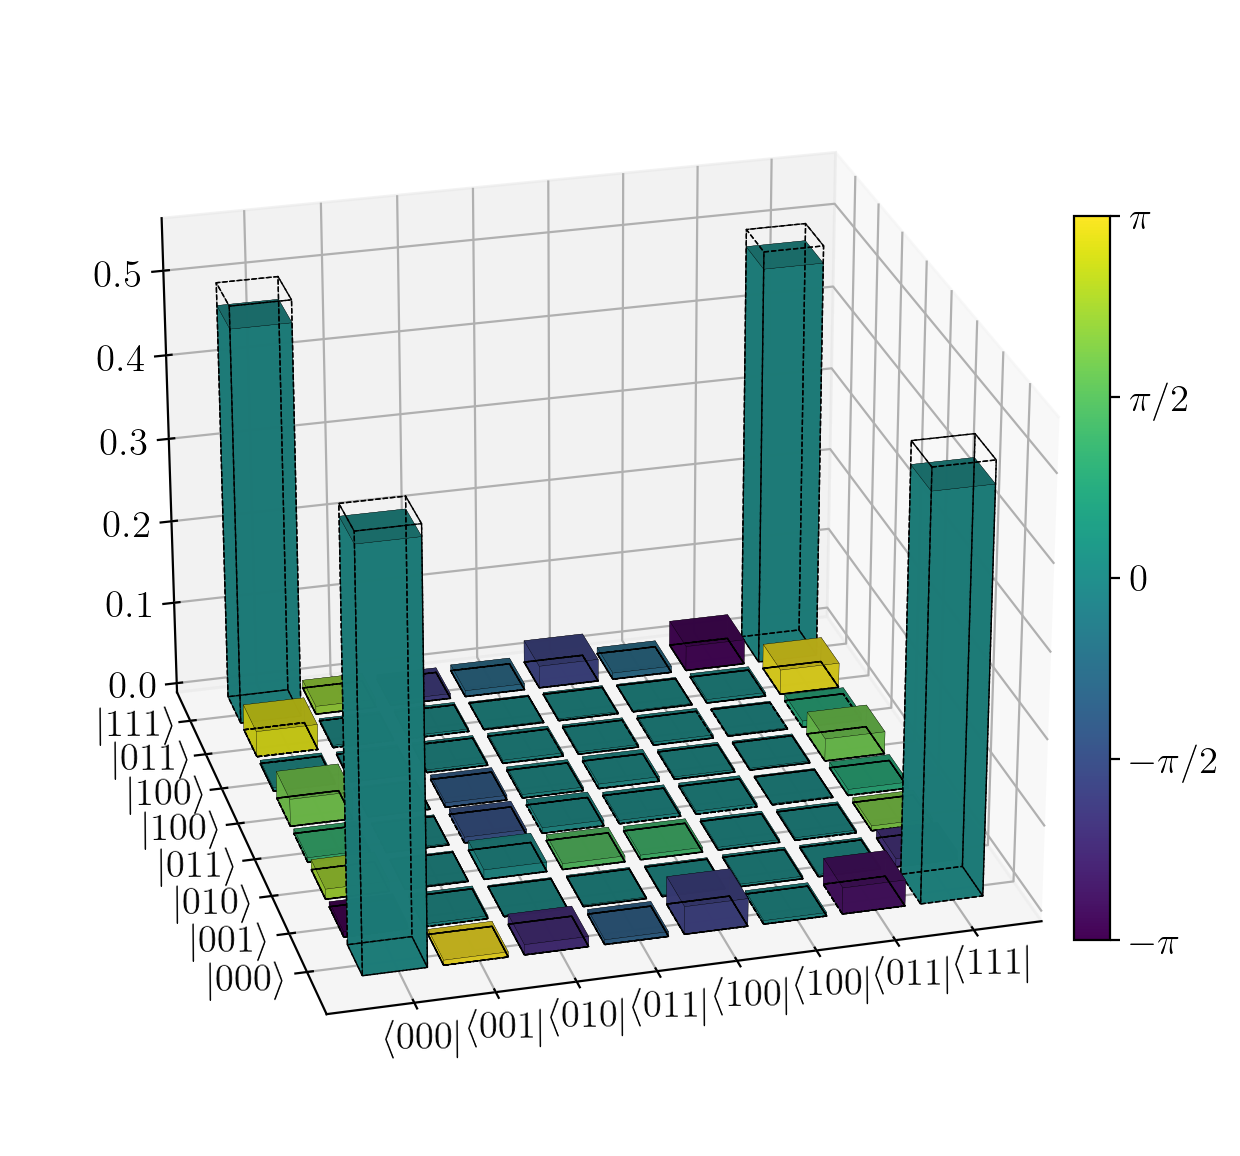

In [17]:
# rho_rot_mat = rotate_matrix(rho, [1.0102]).full()
rho_rot_mat = rho_rot.unit().full()
state_mat = state_dm.full()
n = np.size(rho_rot_mat)
xpos, ypos = np.meshgrid(range(rho_rot_mat.shape[0]), range(rho_rot_mat.shape[1]))
xpos = xpos.T.flatten() - 0.5
ypos = ypos.T.flatten() - 0.5
zpos = np.zeros(n)
dx = dy = 0.8*np.ones(n)
Mvec = rho_rot_mat.flatten()
dz = np.abs(Mvec)
state_vec = state_mat.flatten()
state_dz = np.abs(state_vec)
print(dz.shape, state_dz.shape)

idx, = np.where(abs(Mvec) < 0.005)
Mvec[idx] = abs(Mvec[idx])

phase_min = -np.pi
phase_max = np.pi

norm = mpl.colors.Normalize(phase_min, phase_max)
cmap = plt.get_cmap('viridis')
colors = cmap(norm(np.angle(Mvec)))


labels = [r'$\ket{000}$', r'$\ket{001}$', r'$\ket{010}$', r'$\ket{011}$', r'$\ket{100}$', r'$\ket{100}$', r'$\ket{011}$', r'$\ket{111}$']
labels2 = [r'$\bra{000}$', r'$\bra{001}$', r'$\bra{010}$', r'$\bra{011}$', r'$\bra{100}$', r'$\bra{100}$', r'$\bra{011}$', r'$\bra{111}$']

fig = plt.figure(figsize=(8,8), dpi=200)
ax = fig.add_subplot(projection='3d')
ax.view_init(25, 255)


x1, y1, z1 = sph2cart(*sphview(ax))
camera = np.array((x1, y1, 0))
z_order = getDistances(camera)
max_val = np.max(z_order)


for i in range(n):
    pl1 = ax.bar3d(xpos[i], ypos[i], zpos[i], dx[i], dy[i], dz[i],
                    color= colors[i], alpha=0.9, zsort='max', edgecolor='k', linewidth=0.1)
    pl2 = ax.bar3d(xpos[i], ypos[i], zpos[i], dx[i], dy[i], state_dz[i],
                    color=(0,0,0.1,0), edgecolor='k', linewidth=0.5, linestyle='--')

    pl1._sort_zpos = max_val - z_order[i]
    pl2._sort_zpos = max_val - z_order[i]


# ax.bar3d(xpos, ypos, zpos, dx, dy, GHZdz, color=(0,0,0.1,0), edgecolor='k', linewidth=0.45)
# ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, alpha=1, shade=True, edgecolor='k', linewidth=0.05)
# ax.bar3d(xpos, ypos, zpos, dx, dy, GHZdz, color=(0,0,0.1,0), edgecolor='k', linewidth=0.45)
ax.axes.w_xaxis.set_major_locator(plt.IndexLocator(1, -0.5))
ax.set_xticklabels([r'', r'', r'', r'', r'', r'', r'', r'', r'', r''])
ax.tick_params(axis='x', labelsize=12, labelrotation=45, pad=0)

ax.axes.w_yaxis.set_major_locator(plt.IndexLocator(1, -0.5))
# ax.set_yticklabels([r'', r'$|000\rangle$', r'$|001\rangle$', r'$|010\rangle$', r'$|011\rangle$', r'$|100\rangle$', r'$|101\rangle$', r'$|011\rangle$', r'$|111\rangle$'])
ax.set_yticklabels([r'', r'', r'', r'', r'', r'', r'', r'', r'', r''])
ax.tick_params(axis='y', labelsize=12, labelrotation=-45, pad=0)

ax.tick_params(axis='z', labelsize=14)

font = 14

ax.text(-2.35, -0.4, 0, labels[0], (1,-0.25,0), fontsize=font)
ax.text(-2.35, 0.6, 0, labels[1], (1,-0.25,0), fontsize=font)
ax.text(-2.35, 1.6, 0, labels[2], (1,-0.25,0), fontsize=font)
ax.text(-2.35, 2.6, 0, labels[3], (1,-0.25,0), fontsize=font)
ax.text(-2.35, 3.6, 0, labels[4], (1,-0.25,0), fontsize=font)
ax.text(-2.35, 4.6, 0, labels[5], (1,-0.25,0), fontsize=font)
ax.text(-2.35, 5.6, 0, labels[6], (1,-0.25,0), fontsize=font)
ax.text(-2.35, 6.6, 0, labels[7], (1,-0.25,0), fontsize=font)

ax.text(-0.65, -2.3, 0, labels2[0], (1,-0.25,0.0), fontsize=font)
ax.text(0.35, -2.3, 0, labels2[1], (1,-0.25,0.0), fontsize=font)
ax.text(1.35, -2.3, 0, labels2[2], (1,-0.25,0.0), fontsize=font)
ax.text(2.35, -2.3, 0, labels2[3], (1,-0.25,0.0), fontsize=font)
ax.text(3.35, -2.3, 0, labels2[4], (1,-0.25,0.0), fontsize=font)
ax.text(4.35, -2.3, 0, labels2[5], (1,-0.25,0.0), fontsize=font)
ax.text(5.35, -2.3, 0, labels2[6], (1,-0.25,0.0), fontsize=font)
ax.text(6.35, -2.3, 0, labels2[7], (1,-0.25,0.0), fontsize=font)

ax.set_zlim3d([0,0.55])



cax, kw = mpl.colorbar.make_axes(ax, shrink=0.6, pad=-0.05)
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
cb.set_ticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
cb.set_ticklabels( (r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'))
cb.ax.tick_params(labelsize=14)
plt.tight_layout()

In [18]:
IXYZ = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]

IXYZ_label_list = ['I\n', 'X\n', 'Y\n', 'Z\n']
IXYZ_label = [''.join(prod) for prod in list(it.product(IXYZ_label_list, repeat=3))]

IXYZ_set = [qt.tensor(*prod) for prod in list(it.product(IXYZ, repeat=3))]

eval_list = []
eval_true = []
for i in range(len(IXYZ_set)):
    eval_list.append(qt.expect(IXYZ_set[i], rho_rot.tidyup(1e-5).unit()))

for j in range(len(IXYZ_set)):
    eval_true.append(qt.expect(IXYZ_set[j], state_dm))




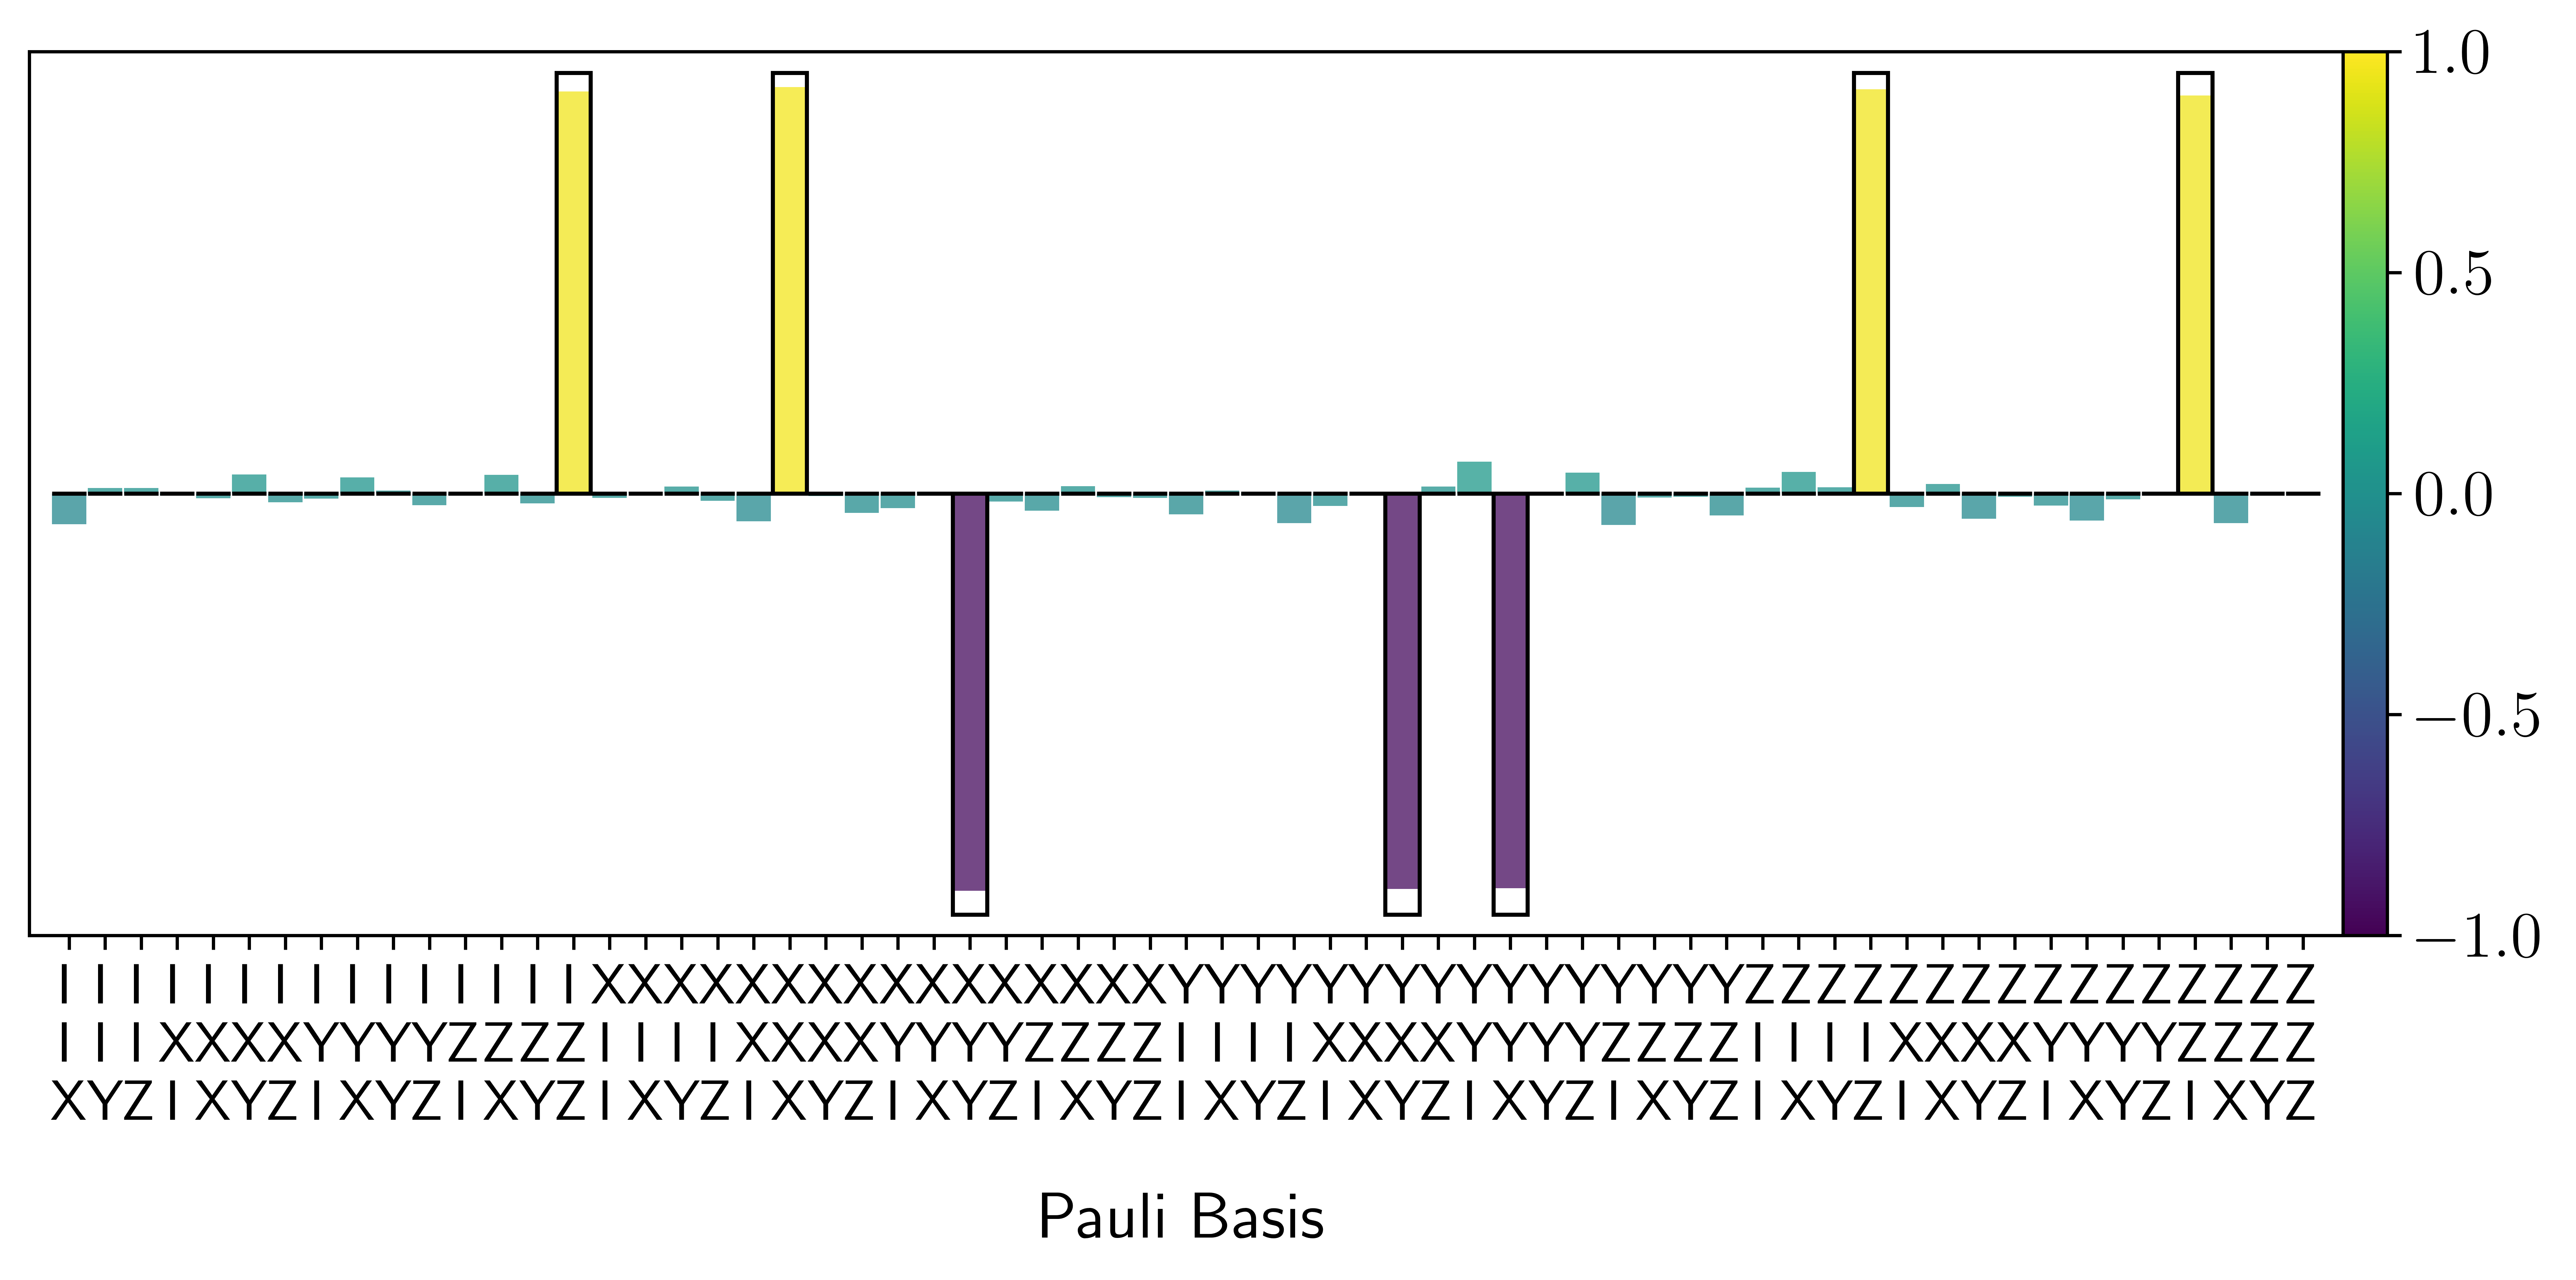

In [19]:
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(12,4), dpi=800)
ax = fig.add_subplot()


rescale = lambda y: (y + 1)/2
cmap = plt.get_cmap('viridis')

sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(-1, 1))

norm = plt.Normalize(-1,1)

ax.bar(IXYZ_label[1:], eval_list[1:], 0.95, alpha=0.75, color=cmap(norm(np.array(eval_list[1:]))))
ax.bar(IXYZ_label[1:], eval_true[1:], 0.95, edgecolor='k', alpha=1, fill=False, linestyle='-')
ax.axes.tick_params('y', labelleft=False, left=False)
ax.axes.tick_params('x', labelsize=14)
ax.set_xlabel('Pauli Basis', fontsize=16, labelpad=1)
ax.set_ylim([-1.05,1.05])
# ax.set_ylabel('Expectation Value', fontsize=16)
cbar = plt.colorbar(sm, pad=0)
cbar.ax.tick_params(labelsize=16)

plt.margins(0.01, 0.02)


In [ ]:
# Setting up bootstrap reconstruction for QST

from IPython import display

N_boot = 1000

F = []
for i in range(N_boot):
    rho_boot = tomo.getDMs(bootstrap=True, n=25000)
    rho_boot = qt.Qobj(rho_boot)
    rho_boot.dims = rho.dims
    if GHZ_bool:
        res = opt.minimize(opt_angle, 
                        [0.0], 
                        args=(rho_boot, state_dm),
                        method='Powell')
    if W_bool:
        res = opt.minimize(opt_angle, 
                        [0.0, 0.0, 0.0], 
                        args=(rho_boot, state_dm),
                        method='Powell')
    F.append(1-res.fun)
    plt.clf()
    plt.hist(F, bins='auto', alpha=0.75)
    plt.title('Sample i={}, last point={:.3f}'.format(i+1, F[-1]*100))
    display.display(plt.gcf())
    display.clear_output(wait=True)

